# Going Deeper_06. 나를 찾아줘 - Class Activation Map 만들기

# 프로젝트: CAM을 만들고 평가해 보자

<준비물>      
프로젝트를 위한 디렉토리 생성   
- mkdir -p ~/aiffel/class_activation_map/data   
- ln -s ~/data/* ~/aiffel/class_activation_map/data

## 1. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

### CAM(Class Activation Map) !!     
CAM 은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어가 붙는 형태로 구성되어야 한다는 제약이 있다. 근데 Grad-CAM 은 제약이 없음!     

둘 다 구현을 하긴 할 건데, 일단 CAM 을 위한 모델을 먼저 구성해서 기본적인 CAM 을 추출하고 그 모델에서 Grad-CAM 을 활용해서 다시 시각화 결과물을 추출하겠다!

### 라이브러리 버전 확인하기

In [1]:
## 필요한 라이브러리 import하기!

## TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

## Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [2]:
##Tensorflow가 활용할 GPU가 장착되어 있는지 확인해보는 코드

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

standford_dogs 데이터셋은 12,000 장의 학습용 데이터셋이랑 8,580장의 평가용 데이터셋으로 구성되어있다. 

In [3]:
## 데이터 준비
## tfds.load 해서 어떤 데이터를 불러올건지 정하기!

## 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의 !!!!!!! 
## stanford_dogs 데이터셋을 불러서 보자~~~~~

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print('슝=3')

슝=3


tfds.show_examples() 를 통해서 각 이미지의 클래스와 인덱스를 확인할 수 있다.

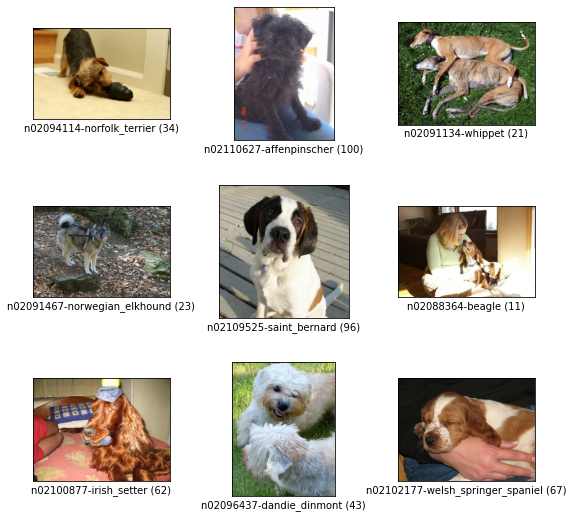

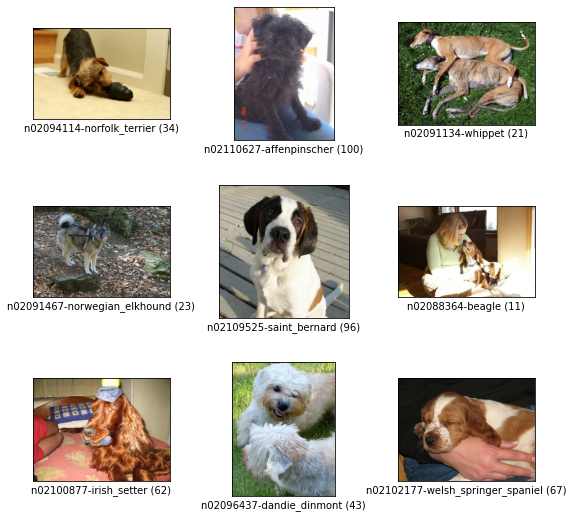

In [4]:
## 데이터 확인하기
## train image 확인

tfds.show_examples(ds_train, ds_info)

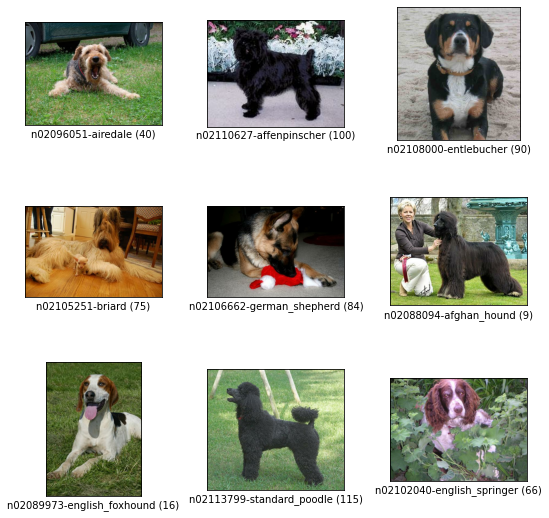

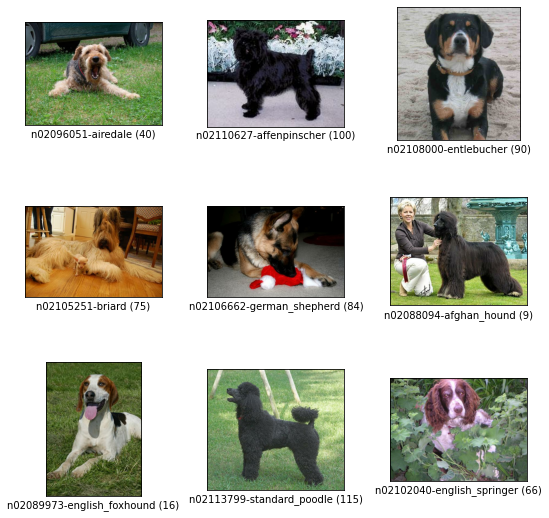

In [5]:
## test image 확인

tfds.show_examples(ds_test, ds_info)

## 2. CAM, Grad-CAM용 모델 준비하기 (2) 물체의 위치정보

df_info 를 조회해서 features 가 어떻게 구성되어 있는지 확인해보자!

In [6]:
## 데이터의 feature들을 불러오는 코드다! 
## 자세히 보는 것을 추천
## 딕셔너리로 되어있음 -> key 값이랑 value값
## bbox 는 bounding box를 의미한다.

## Image(shape=(None, None, 3) 이걸 보면 이미지의 크기가 딱 명확하지 않아서 
## 가로 세로에  None이 왔다

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

![alt text](3.png "Title")

위에 키 중에서 'bbox' 라는게 있는데 bbox는 바운딩 박스이다. 위에 사진처럼 물체의 위치를 사각형 영역으로 표기하는 방법이다. 

## 3. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

CAM 을 얻어내기 위해서 모델을 만들어 볼 것이다. 이미지넷 데이터에 훈련이 된 ResNet 50 을 기반으로 하고, 후에 pooling layer 뒤에 소프트맥스 레이어를 붙여서 Grad-CAM 모델을 만들어보자!       

**참고* *   
소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.

### 3-1 구현해 보기

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,     ## Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      ## GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

CAM은 특성 맵(feature map)을 사용해 만든다.   
-> 해당 feature map은 conv5_block3_out의 output이다.

따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행한다.

## 4. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

- 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행    
- 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성    

CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이다.

In [9]:
def normalize_and_resize_img(input):
    ## Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')  

슝=3


In [10]:
## dataset에 전처리와 배치처리 적용

ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)


## 구성된 배치의 모양 확인

for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3') 

슝=3


/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 159s 205ms/step - loss: 0.0253 - accuracy: 0.9969 - val_loss: 1.0701 - val_accuracy: 0.7180
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0099 - accuracy: 0.9991 - val_loss: 1.0080 - val_accuracy: 0.7334
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0043 - accuracy: 0.9999 - val_loss: 1.0289 - val_accuracy: 0.7326
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 1.0360 - val_accuracy: 0.7339
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.0429 - val_accuracy: 0.7337
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.0511 - val_accuracy: 0.7376
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 1.0226 -

In [14]:
## 학습시킨 가중치를 저장해주자!

import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


저장 완료!


## 5. CAM

이제 학습된 모델을 활용하여 CAM을 생성해 볼 것이다.

![alt text](4.png "Title")

CAM(Class Activation Map) 은 이름에서 알 수 있듯이 클래스가 활성화되는 지도이다. 
CNN 레이어를 거친 특성 맵에도 입력값의 위치정보가 유지되기 때문에! → 맵의 정보를 이미지 검출(detection) 이나 세그멘테이션(Segmentation) 등의 문제를 푸는데 이용함

In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    ## Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


이제 학습된 모델에서 CAM을 생성해보자!!!!!!!!!!!!!!!!!!!!!!
CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했다.

In [16]:
## Dataset에서 한 장씩 

def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


100


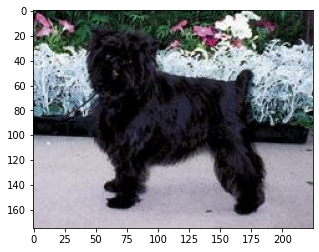

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

### CAM 구현하기

CAM을 생성하기 위해서는    
1. 특성 맵   
2. 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치   
3. 원하는 클래스의 출력값   
이 필요하다.    



이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에 나온 CAM을 이미지 사이즈와 같게 만들어 함께 시각화 해야 함.


- model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수 만들기  
- generate_cam()을 구현: conv_outputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현  
- 입력 이미지에 맞춰 CAM을 resize해주기

In [18]:
## 이제 데이터가 준비완료
## CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러오기

import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [19]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    ## 학습한 모델에서 원하는 layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    ## model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolutuon layer의 output을 얻을 수 있음
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] ## 마지막 모델의 weight activation 가져오기
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        ## W * f를 통해 class별 activation map 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) ## activation score를 normalize하기
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) ## 원래 이미지의 크기로 resize
    return cam_image

print('슝=3')

슝=3


이제 위에서 작성한 함수를 실행하면 아래와 같은 CAM을 얻을 수 있다. 생각보다 위치를 정확하게 표현하고 있다.

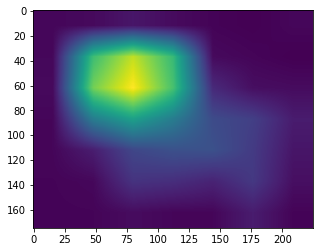

In [20]:
## 위 함수 실행

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [21]:
## CAM 이미지를 원본 이미지와 합치기

def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


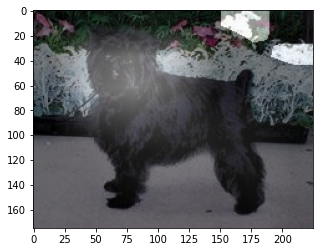

In [22]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

생성된 CAM이 개를 식별하는데 중요한 이미지 부분을 잘 포착하고 있나????? 주로 강아지의 얼굴과 몸통이 있는 부분이 강조되는 경향이 있는데, 이것은 사람이 개를 식별할 때 유의해서 보는 부분과 일맥상통한다.

## 6. Grad-CAM

### Grad-CAM 구현하기

이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용

#### Grad-CAM을 이용해서 CAM을 만들기!!!     
- grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.   
- 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 된다.     
- 이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 한다.

75


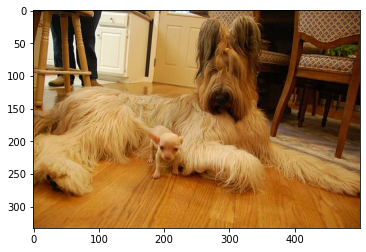

In [23]:
## 우선 새로운 이미지를 뽑아주기

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [24]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    ## Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    ## 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    ## Gradient를 얻기 위해 tape 사용
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor,0))
        
        loss = pred[:, class_idx] ## 원하는 class 예측값 얻기
        output = conv_output[0]
        grad_val = tape.gradient(loss, conv_output)[0] ## 예측값에 따른 Layer의 gradient 얻기
        
    weights = np.mean(grad_val, axis=(0,1)) ## gradient의 GAP으로 class별 weight를 구함
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        ## 각 class별 weight와 해당 layer의 output을 곱해 class activation map 얻기
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보자!         
( 레이어의 이름은 이전 스탭의 cam_model.summary() 결과에서 찾을 수 있다.) 

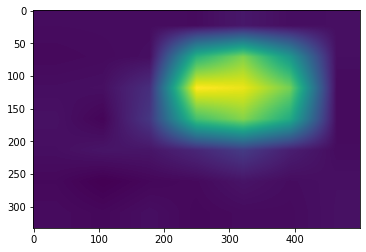

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out',item)
plt.imshow(grad_cam_image)
plt.show()

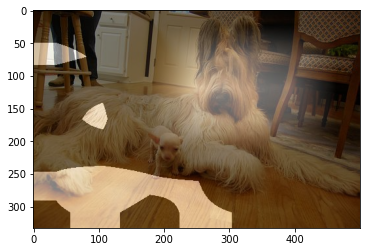

In [26]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

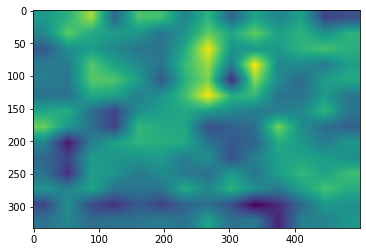

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

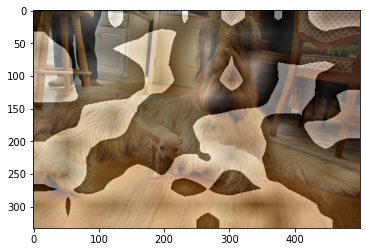

In [28]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

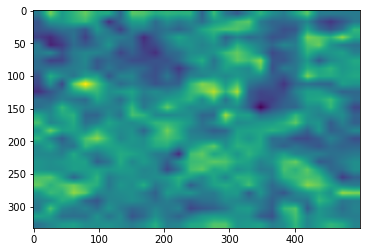

In [29]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

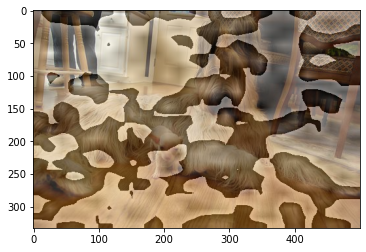

In [30]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 7. Detection with CAM

### 바운딩 박스 구하기

80


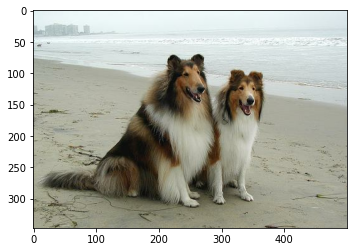

In [31]:
## 새로운 이미지를 다시 뽑기

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

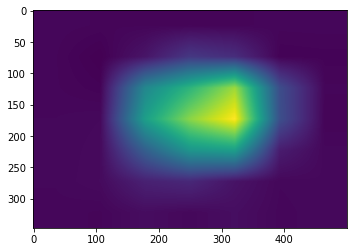

In [32]:
## 이전 스텝에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑기

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

#### get_bbox() 함수는 바운딩 박스를 만들기 위해서!!    

1. score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.  
2. OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다.  
3. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다.  
4. boxPoints()로 이를 꼭지점으로 바꿔 준다.  
5. int 자료형으로 변환

In [33]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [34]:
## cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있다.

rect = get_bbox(cam_image)
rect

array([[113,  42],
       [447,  42],
       [447, 297],
       [113, 297]])

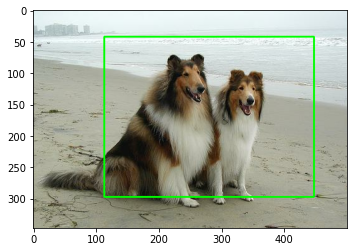

In [35]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0.0,255), 2)
plt.imshow(image)
plt.show()

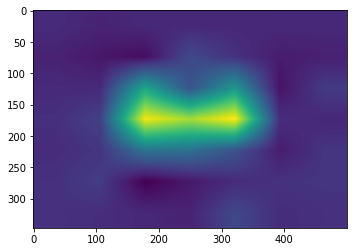

In [36]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

In [37]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

array([[285, 290],
       [369, 290],
       [369, 346],
       [285, 346]])

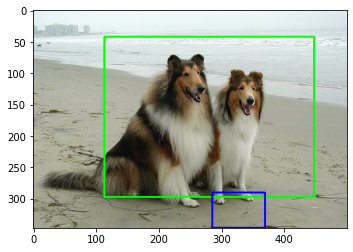

In [38]:
image = cv2.drawContours(image,[grad_rect],0,(0,0,255),2)
plt.imshow(image)
plt.show()

### IoU 구하기

![alt text](2.png "Title")

IoU 는 Intersection Over Union 이다. IoU 는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [39]:
## rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어짐

def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]), ## bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]), ## bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), ## bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]), ## bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


In [40]:
## cam_image를 통한 bbox를 minmax bbox 형태로 치환

pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.12103746397694524, 0.226, 0.8559077809798271, 0.894]

In [41]:
## grad_cam_image를 통한 bbox를 minmax bbox 형태로 치환

grad_pred_bbox = rect_to_minmax(grad_rect, item['image'])
pred_bbox

[0.12103746397694524, 0.226, 0.8559077809798271, 0.894]

In [42]:
## ground truth bbox

item['objects']['bbox']

array([[0.19596542, 0.02      , 0.9048991 , 0.578     ],
       [0.26224783, 0.584     , 0.89048994, 0.736     ]], dtype=float32)

In [43]:
## CAM 추론 결과로 얻어진 bbox가 ground truth bbox와 비슷한지 IoU 계산해서 확인

def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = max(boxA[2], boxB[2])
    x_max = max(boxA[3], boxB[3])
    
    interArea = max(0, x_max-x_min) * max(0, y_max-y_min)
    boxAArea = (boxA[2] - boxA[0] * (boxA[3] - boxA[1]))
    boxBArea = (boxB[2] - boxB[0] * (boxB[0] - boxB[1]))
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

print('슝=3')

슝=3


In [44]:
## cam bbox와 ground truth bbox와 비슷한지

get_iou(pred_bbox, item['objects']['bbox'][0])

0.4041014574039023

In [45]:
## grad_cam bbox와 ground truth bbox와 비슷한지

get_iou(grad_pred_bbox, item['objects']['bbox'][0])

0.01594829424684267

< 결과 >   
- Bbox의 경우 CAM의 경우 object detection을 green bbox 하나로 한 반면에, Grad-CAM은 green, blue 두 개로 bbox가 detection 되었다.   
- CAM, Grad-CAM 모두 object를 잘 찾았다. CAM은 강아지의 얼굴 부위에 더 집중되어 있었고, Grad-CAM은 CAM보다는 더 작은 특정 부위에 덜 진하게 집중되어 있었다.
- IoU 를 보면 cam 이 0.4041014574039023, grad_cam이 0.01594829424684267 로 Grad-CAM 가 더 높은 점수였다. 그니까 bbox와 ground truth bbox와 비슷한지를 보는 것이니까 Grad- CAM 이 겹치는 영역이 더 넓고 더 비슷한 것을 알 수 있다.!

# 회고!

## < 어려웠던 점>  
이번에 Lecture 5번 노드를 열심히 봤다... 근데 이해를 한 부분도 코드로 보니까 너무 어렵고 정신이 없었당... 그래도 이번에는 노드를 열심히 보고 따라하면 할 수 있어서 다행이었다. 그래도 아직 코드를 보면 이해를 안되는 부분이 많다.. 열심히 구글링을 하면서 복습을 해야겠다! 그리고 모델을 만드는 것은 아직까지 너무 어렵다.....진짜 봐도봐도 모르겠고 저걸 혼자서 어떻게 해야할지도 막막하다ㅜㅜ 2번 노드를 다시 공부하러 가야겠다....

## < 알아낸 점> & < 아직까지 모호한 점>  
이번에 Lecture 노드를 열심히 보면서 정리를 열심히 했다. 그래서 코드를 구현하면서 개념이 흔들릴 때마다 찾아보면서 공부를 했더니 CAM 에 대해서 조금을 알 것 같다. 그리고 사실 개념을 볼 때는 CAM 이랑 Grad-CAM 의 차이가 명확하게 머릿속에 들어오지 않았다. 근데 코드의 결과값을 보면서 다시 한 번 이론을 보니까 좀 더 명확하게 이해가 되는 듯 한데 그래도 복습이 필요한 것 같다. 그리고 함수를 정의할 때 순서대로 노드 글이랑 보니까 도움이 되었다.   

#### get_bbox() 함수는 바운딩 박스를 만들기 위해서!!    

1. score_thresh를 받아 역치값 이하의 바운딩 박스는 없앤다.  
2. OpenCV의 findContours()와 minAreaRect()로 사각형을 찾는다.  
3. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있다.  
4. boxPoints()로 이를 꼭지점으로 바꿔 준다.  
5. int 자료형으로 변환  

이 순서가 노드에 적혀있어서 정리를 해서 코드랑 보니까 더 이해가 잘 가는 듯 했다.! 으음 전부 다 이렇게 하지는 못해도 중요개념을 함수로 정의하는 것은 이런 식으로 정리해서 봐야겠다!

## < 자기 다짐>  
역시나 GD노드는 너무 어렵다,, 익스랑 비교가 안된다.. 이번 노드는 순서대로 잘 읽고 따라하고 조금만 변경하면 되는 것이었지만 그래도 내용이 너무 어려웠던 것 같다. 그래도 확실히 Lecture 노드를 열심히 보고 안보고가 큰 것 같다. CV 사람들이랑 같이 노드를 보는 것이 부담은 되지만 도움은 많이 되는 것 같아서 너무 좋다! 노드가 밀리지 않고 모르는 것을 서로 공유하는 것이 진짜 도움이 많이 되고 의지력도 더 생기는 것 같다. 앞으로도 열심히 했으면 좋겠다! 지금도 충분히 잘하지만@!! 지치지 말고 2개월 남았는데 화이팅!!!!!